# Научно-исследовательская работа на тему "Вычисление относительного радиуса звезд"

В данном проекте анализируется набор данных НАСА о звездах - https://www.kaggle.com/datasets/brsdincer/star-type-classification

Данные содержатся в файле Stars.csv

В наборе данных содержатся основные физические и астрономические характеристики звезд. Относительный радиус звезды характеризует ее размер относительно размера Солнца.

Датасет содержит следующие столбцы:
* Temperature - температура в Кельвинах
* L - относительная яркость
* R - относительный радиус
* A_M - абсолютная звездная величина
* Color - цвет
* Spectral_Class - спектральный класс
* Type - тип


Будем решать задачу регрессии, используя в качестве целевого признака R.


## Импорт библиотек

Импортируем необходимые библиотеки и отключим предупреждения об ошибках.

In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import opendatasets as od
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
import sklearn.metrics
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import ShuffleSplit, KFold

warnings.filterwarnings('ignore')

## Загрузка данных

Данные хранятся в csv-файле. Загрузим его  с помощью pandas и удалим дубликаты.

In [2]:
od.download('https://www.kaggle.com/datasets/brsdincer/star-type-classification')

Skipping, found downloaded files in "./star-type-classification" (use force=True to force download)


In [135]:
stars = pd.read_csv("star-type-classification/Stars.csv")
stars = stars.drop_duplicates()

## Разведочный анализ данных. Визуализация данных и обработка пропусков.

### Основные характеристики датасета

In [4]:
# Первые строки датасета
stars.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [5]:
# Размер датасета
stars.shape

(240, 7)

In [6]:
# Список столбцов с типами
stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
 6   Type            240 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


In [7]:
# Проверим наличие пропусков
stars.isnull().sum()

Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
Type              0
dtype: int64

Вывод: набор данных не содержит пропуски, но содержит категориальные признаки. 

### Визуализация данных

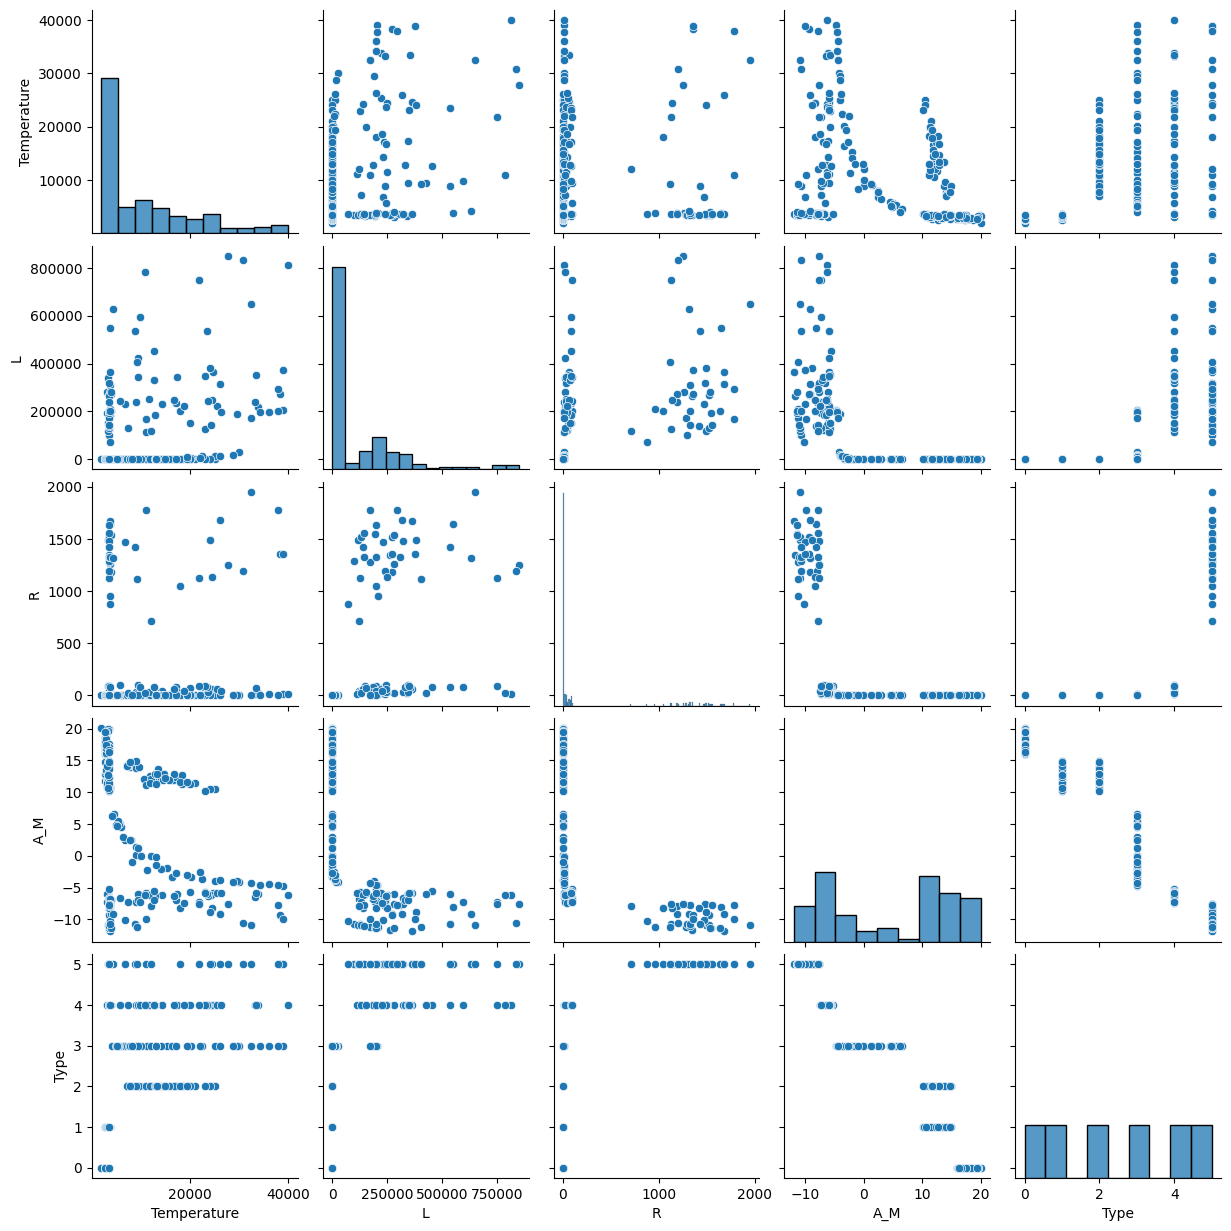

In [8]:
sns.pairplot(stars)

In [9]:
# значения категориальных признаков
stars['Color'].value_counts()

Color
Red                   112
Blue                   56
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              4
white                   3
Yellowish White         3
yellowish               2
Whitish                 2
Orange                  2
White-Yellow            1
Pale yellow orange      1
Yellowish               1
Orange-Red              1
Blue-White              1
Name: count, dtype: int64

In [10]:
stars['Spectral_Class'].value_counts()

Spectral_Class
M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: count, dtype: int64

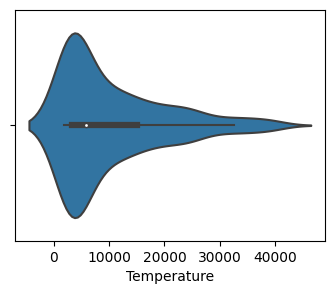

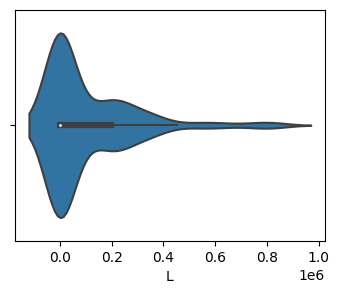

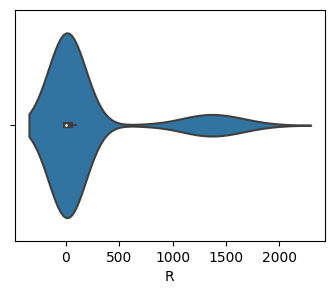

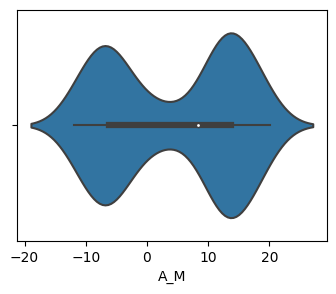

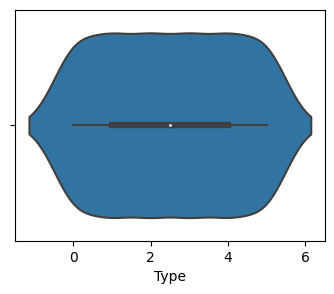

In [11]:
#скрипичные диаграммы для числовых столбцов
for col in ['Temperature', 'L', 'R', 'A_M', 'Type']:
    fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(4,3))
    sns.violinplot(x=stars[col])
    plt.show()

## Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных.

Столбцы Color и Spectral_Class содержит категориальные значения, которые нужно закодировать.

Данные должны быть масштабированы.

In [136]:
# кодирование категориального признака
oe = OrdinalEncoder()
stars[["Color", "Spectral_Class"]] = oe.fit_transform(stars[["Color", "Spectral_Class"]])

In [137]:
# масштабирование
scaler = MinMaxScaler()
sc_cols = list(stars)
sc_stars = pd.DataFrame(columns=sc_cols)
sc_data = scaler.fit_transform(stars)

# создадим датафрейм с масштабированными данными
for i in range(len(sc_cols)):
    col = sc_cols[i]
    sc_stars[col] = sc_data[:,i]
    
sc_stars.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,0.029663,2.731275e-09,0.000083,0.876798,0.5,0.833333,0.0
1,0.028980,4.944550e-10,0.000075,0.891807,0.5,0.833333,0.0
2,0.017367,2.590003e-10,0.000048,0.957473,0.5,0.833333,0.0
3,0.022622,1.412729e-10,0.000078,0.893371,0.5,0.833333,0.0
4,0.000000,6.828189e-11,0.000049,1.000000,0.5,0.833333,0.0


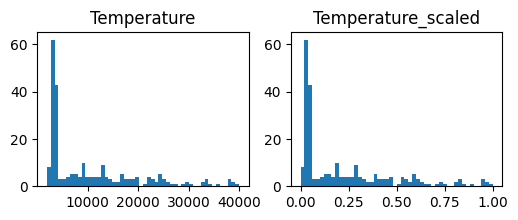

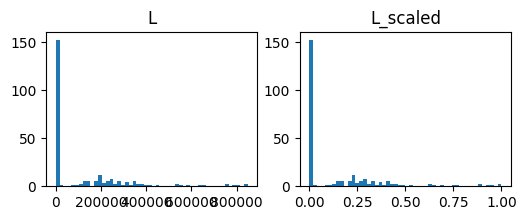

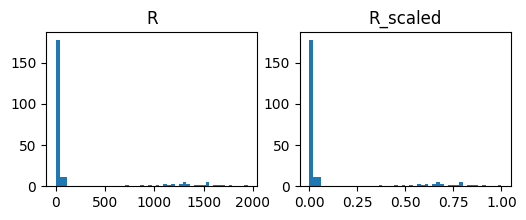

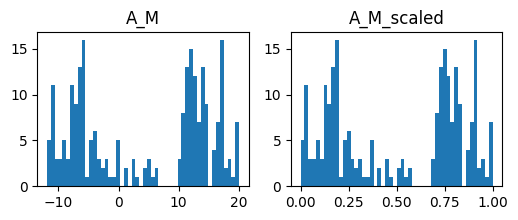

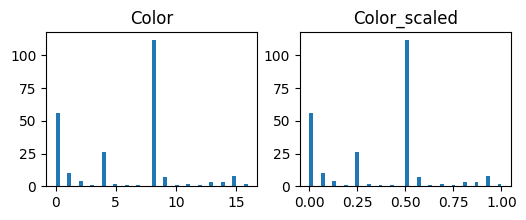

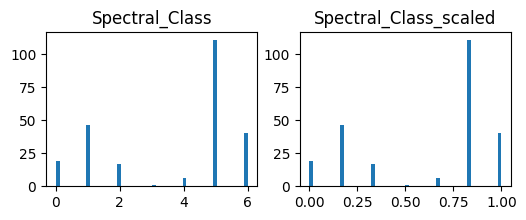

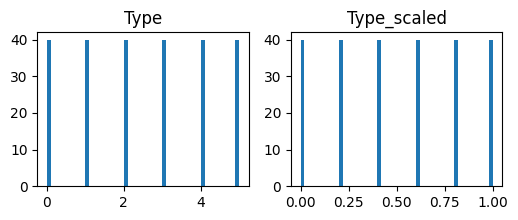

In [138]:
# Убедимся, что масштабирование не повлияло на распределение данных
for col in sc_cols:
    col_scaled = col + '_scaled'
    fig, ax = plt.subplots(1, 2, figsize=(6,2))
    ax[0].hist(stars[col], 50)
    ax[1].hist(sc_stars[col], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()



## Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.

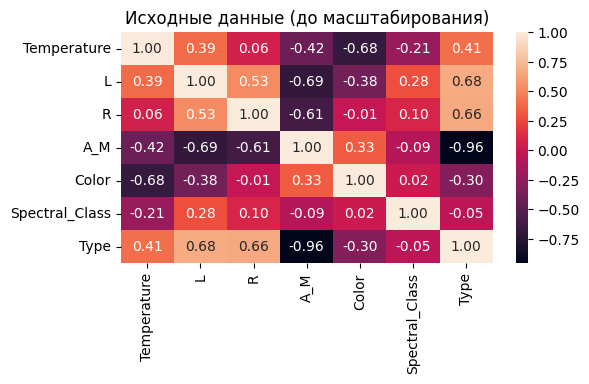

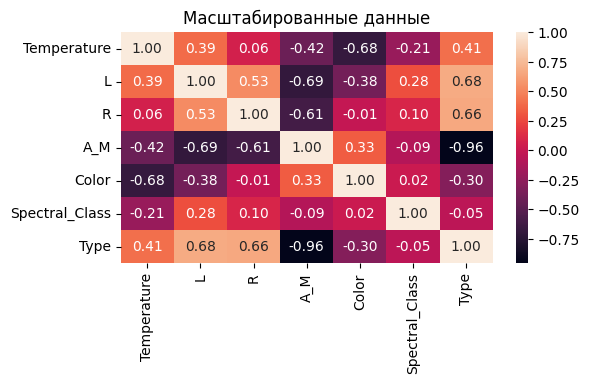

In [139]:
fig, ax = plt.subplots(figsize=(6,3))
sns.heatmap(stars.corr(), annot=True, fmt='.2f')
ax.set_title('Исходные данные (до масштабирования)')
plt.show()

fig, ax = plt.subplots(figsize=(6,3))
sns.heatmap(sc_stars.corr(), annot=True, fmt='.2f')
ax.set_title('Масштабированные данные')
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы:
  * после масштабирования матрица корреляций не изменилась.
  * целевой признак регрессии - R - сильнее всего коррелирует с Type и A_M. Эти признаки обязательно нужно включить в модель.
  * Type и  A_M, в свою очередь, имеют коэф. корреляции, близкий к -1. Из этих двух признаков можно оставить Type, т.к он сильнее коррелирует с целевым.


## Выбор метрик для оценки качества моделей

Выберем метрики, подходящие для задачи регрессии:

* Mean squared error (MSE) - средняя квадратичная ошибка.
    $$MSE(y,\hat{y}) = \frac{1}{N} \cdot \sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2 $$
     где:
     - $y$ - истинное значение целевого признака
     - $\hat{y}$ - предсказанное значение целевого признака
     - $N$ - размер тестовой выборки
     
* Median absolute error (MedAE)
    $$MedAE(y,\hat{y}) = median( \lvert  y_1 - \hat{y_1} \rvert, \dots, \lvert  y_N - \hat{y_N} \rvert)$$
   
   В данных могут быть выбросы, а эта метрика к ним устойчива.
    
* Метрика $R^2$ - коэффициент детерминации
    $$R^2(y,\hat{y}) = 1 - \frac{\sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2}{\sum\limits_{i=1}^N ( y_i - \overline{y_i} )^2} $$
     где:
     - $y$ - истинное значение целевого признака
     - $\hat{y}$ - предсказанное значение целевого признака
     - $N$ - размер тестовой выборки
     - $\overline{y_i} = \frac{1}{N} \cdot \sum\limits_{i=1}^N y_i $
     
Метрики вычисляются с помощью встроенных функций sklearn.

Значения MSE и MedAE должны быть минимальны, а значение $R^2$ - близко к 1.

In [175]:
# функция для вывода значений метрик
def print_metrics(mse, medae, r2):
# mean squared error
    print('MedAE={}, MSE={}, R2={}'.format(round(medae, 5), round(mse, 5), round(r2, 5)))
    
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = {'metric':metric, 'alg':alg, 'value':value}
        #self.df = self.df.append(temp, ignore_index=True)
        self.df.loc[len(self.df)] = temp

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(4,4)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()    



## Выбор моделей для решения задачи регрессии

Будем использовать следующие модели:
* Метод ближайших соседей
* Линейная регрессия
* Машина опорных векторов
* Бэггинг
* Градиентный бустинг


## Разделение исходного набора данных на обучающую и тестовую выборки

In [144]:
# признаки для построения модели
feats = list(stars)
feats.remove('A_M')
feats.remove('R')
# целевой признак
targ = ['R']
x_train, x_test, y_train, y_test = train_test_split(
    sc_stars[feats], sc_stars[targ], random_state=1)
x_test.head()

,Temperature,L,Color,Spectral_Class,Type
228,0.555845,4.094794e-01,0.000,1.000000,0.8
194,0.041617,6.263097e-09,0.500,0.833333,0.2
88,0.309529,1.177274e-10,0.875,0.333333,0.4
95,0.244634,7.911280e-04,0.250,0.000000,0.6
214,0.847350,2.333357e-01,0.000,1.000000,0.6


In [145]:
y_test.head()

,R
228,4.413239e-02
194,1.594054e-04
88,2.668731e-07
95,3.577947e-03
214,3.275149e-03


In [146]:
x_test.shape

(60, 5)

In [147]:
x_train.shape

(180, 5)

## Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. 

Обучим выбранные модели и выведем значения метрик для них.

In [176]:
# модели
def_models = {'KNN_5':KNeighborsRegressor(n_neighbors=5),
              'LR': LinearRegression(), 
              'SVR':SVR(),
              'BR':BaggingRegressor(),
              'GBR':GradientBoostingRegressor()
}

#сохранение меток
def_mlogger = MetricLogger()

In [177]:
def regr_train_model(model_name, model, logger):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    mse = mean_squared_error(y_test, pred)
    medae = median_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    logger.add('MSE', model_name, mse)
    logger.add('MedAE', model_name, medae)
    logger.add('R2', model_name, r2)    
    print(model_name)
    print_metrics(medae, mse, r2)

In [178]:
for model_name, model in def_models.items():
    regr_train_model(model_name, model, def_mlogger)

KNN_5
MedAE=0.02416, MSE=0.00014, R2=0.70608
LR
MedAE=0.04564, MSE=0.10553, R2=0.4448
SVR
MedAE=0.01661, MSE=0.0745, R2=0.7979
BR
MedAE=0.0059, MSE=7e-05, R2=0.92824
GBR
MedAE=0.00659, MSE=0.00064, R2=0.91983


Полученные модели имеют достаточно высокое качество. Наилучшей является модель BaggingRegressor, наихудшей - LinearRegressor.

## Подбор гиперпараметров для выбранных моделей



In [151]:
n_range = np.array(range(2,20,1))
estimators_range = np.array(range (10, 20, 1))
gbr_estimators_range = np.array(range (100, 200, 10))
knn_params = {'n_neighbors': n_range, 'weights':('uniform', 'distance')}
svr_params = {'kernel':('linear', 'poly', 'rbf')}
br_params = {'estimator':(DecisionTreeRegressor(), SVR()), 'n_estimators':estimators_range}
gbr_params = {'loss': ('squared_error', 'absolute_error', 'huber'), 'n_estimators':gbr_estimators_range}

In [152]:
#knn
regr_gs = GridSearchCV(KNeighborsRegressor(), knn_params, cv=5, scoring='neg_mean_squared_error')
regr_gs.fit(x_train, y_train)

# Лучшая модель
best_knn = regr_gs.best_estimator_
best_knn

KNeighborsRegressor(n_neighbors=4, weights='distance')

In [153]:
#svr
regr_gs = GridSearchCV(SVR(), svr_params, cv=5, scoring='neg_mean_squared_error')
regr_gs.fit(x_train, y_train)

# Лучшая модель
best_svr = regr_gs.best_estimator_
best_svr

SVR(kernel='poly')

In [154]:
# Изменение качества
df = pd.DataFrame(
            {'kernel': pd.Series([], dtype='str'),
            'score': pd.Series([], dtype='float')})
for i in range (0, 3):
    tmp = {'kernel':svr_params['kernel'][i], 'score':regr_gs.cv_results_['mean_test_score'][i]}
    df.loc[len(df)] = tmp

<Axes: xlabel='kernel', ylabel='score'>

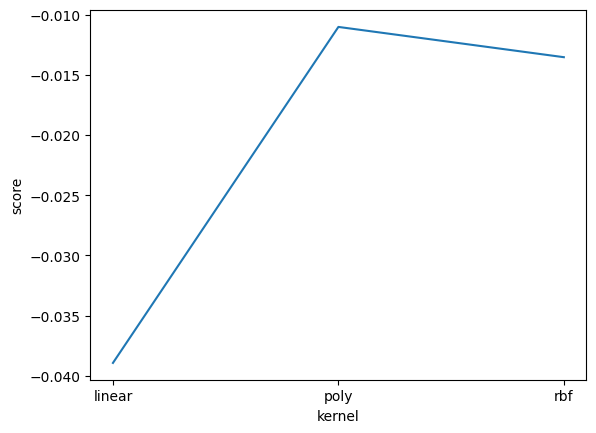

In [155]:
sns.lineplot(data=df, x='kernel', y='score')

In [156]:
#br
regr_gs = GridSearchCV(BaggingRegressor(), br_params, cv=5, scoring='neg_mean_squared_error')
regr_gs.fit(x_train, y_train)

# Лучшая модель
best_br = regr_gs.best_estimator_
best_br

BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=13)

In [157]:
#gbr
regr_gs = GridSearchCV(GradientBoostingRegressor(), gbr_params, cv=5, scoring='neg_mean_squared_error')
regr_gs.fit(x_train, y_train)

# Лучшая модель
best_gbr = regr_gs.best_estimator_
best_gbr

GradientBoostingRegressor(loss='absolute_error', n_estimators=140)

## Сравнение полученных моделей с baseline-моделями

### Кросс-валидация

Проведем кросс-валидацию моделей на перемешиваемом наборе данных и построим график значений оценки кросс-валидации для модели по умолчанию и наилучшей модели.

In [158]:
#ShuffleSplit
def plot_validation(def_model, best_model, feats, targ, n):
    scores = pd.DataFrame(
            {'n': pd.Series([], dtype='int'),
            'score': pd.Series([], dtype='float'),
            'type': pd.Series([], dtype='str')})
    #for i in range (0, 19):
    ss = ShuffleSplit(n_splits=n, test_size=0.25)

    def_scores = cross_val_score(def_model, feats, targ, scoring='r2', cv=ss)
    best_scores = cross_val_score(best_model, feats, targ, scoring='r2', cv=ss)
    for j in range (0, n):
        scores.loc[len(scores)] = {'n':j , 'score':def_scores[j], 'type': 'default'}
        scores.loc[len(scores)] = {'n':j, 'score':best_scores[j], 'type': 'best'}
    sns.scatterplot(scores, x='n', y='score', hue='type')


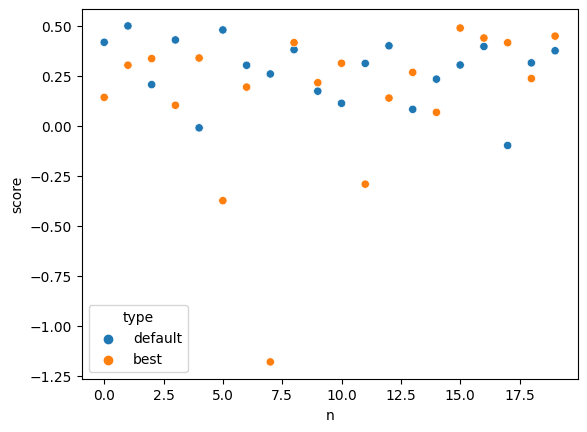

In [159]:
plot_validation(KNeighborsRegressor(n_neighbors=5), best_knn, stars[feats], stars[targ], 20)

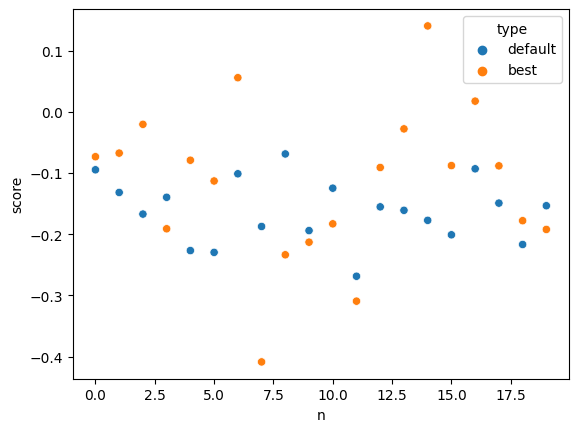

In [160]:
plot_validation(SVR(), best_svr, stars[feats], stars[targ], 20)

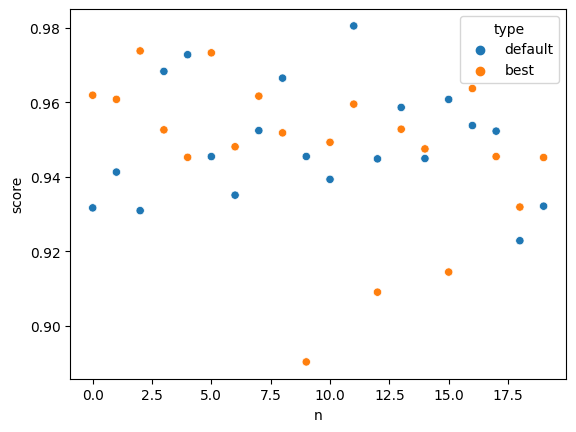

In [161]:
plot_validation(BaggingRegressor(), best_br, stars[feats], stars[targ], 20)

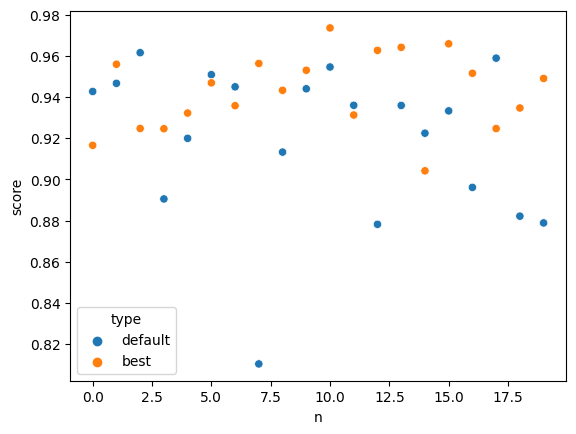

In [162]:
plot_validation(GradientBoostingRegressor(), best_gbr, stars[feats], stars[targ], 20)

По результатам кросс-валидации заметное превосходство модели с подобранными гиперпараметрами над моделью по умолчанию наблюдается у машины опорных векторов и градиентного бустинга.

## Выводы о качестве построенных моделей на основе выбранных метрик.

In [173]:
# Метрики качества модели
clas_metrics = def_mlogger.df['metric'].unique()
clas_metrics

array(['MSE', 'MedAE', 'R2'], dtype=object)

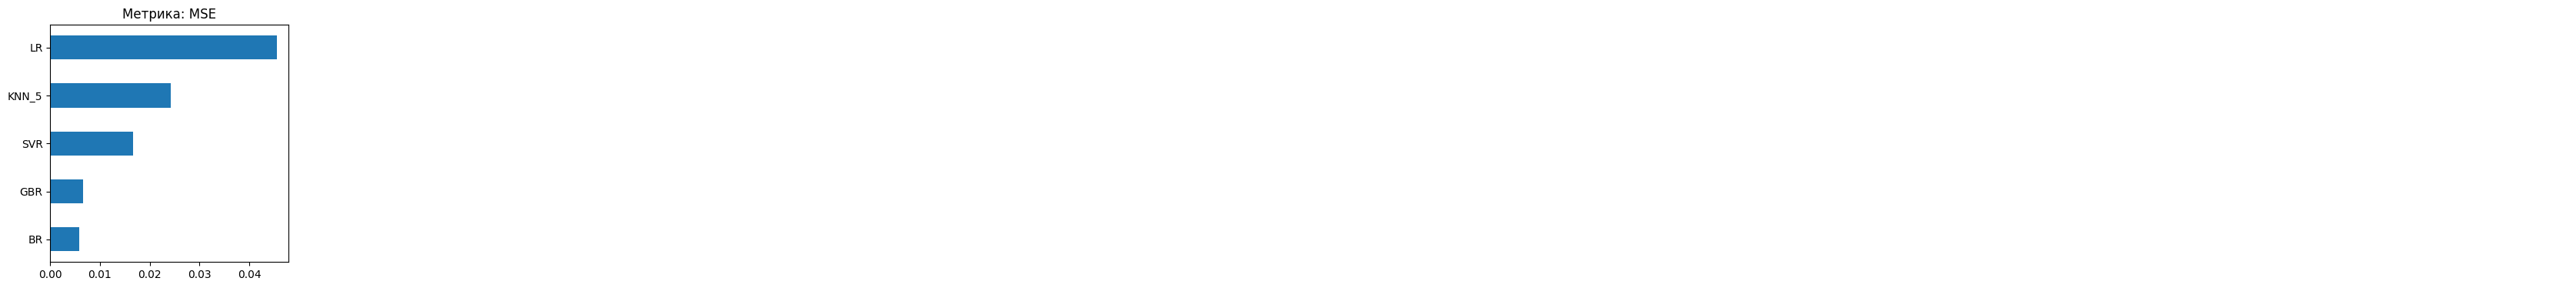

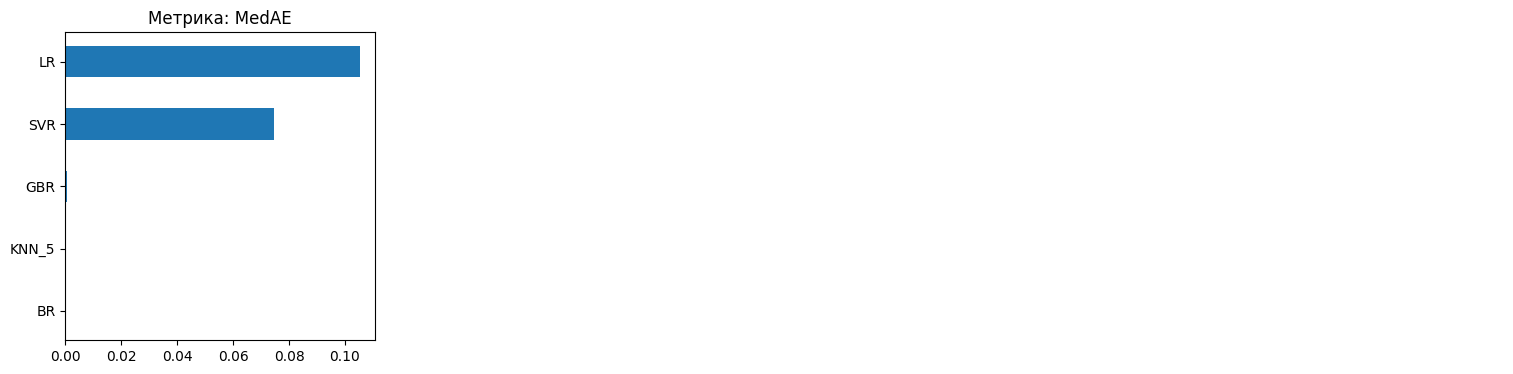

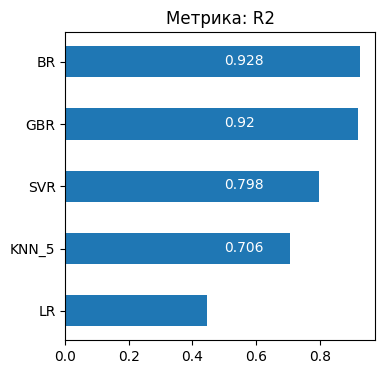

In [182]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    def_mlogger.plot('Метрика: ' + metric, metric,)

Из baseline-моделей наилучшей оказалась модель бэггинга.

In [183]:
best_models = {'KNN_5':best_knn, 
              'SVR':best_svr,
              'BR':best_br,
              'GBR':best_gbr
}

#сохранение меток
best_mlogger = MetricLogger()

In [184]:
for model_name, model in best_models.items():
    regr_train_model(model_name, model, best_mlogger)

KNN_5
MedAE=0.02108, MSE=8e-05, R2=0.74359
SVR
MedAE=0.01154, MSE=0.09731, R2=0.85967
BR
MedAE=0.0052, MSE=7e-05, R2=0.93668
GBR
MedAE=0.00493, MSE=0.0001, R2=0.94


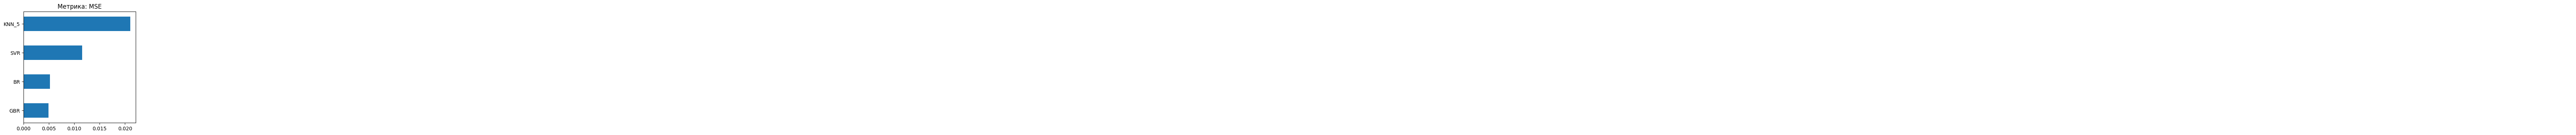

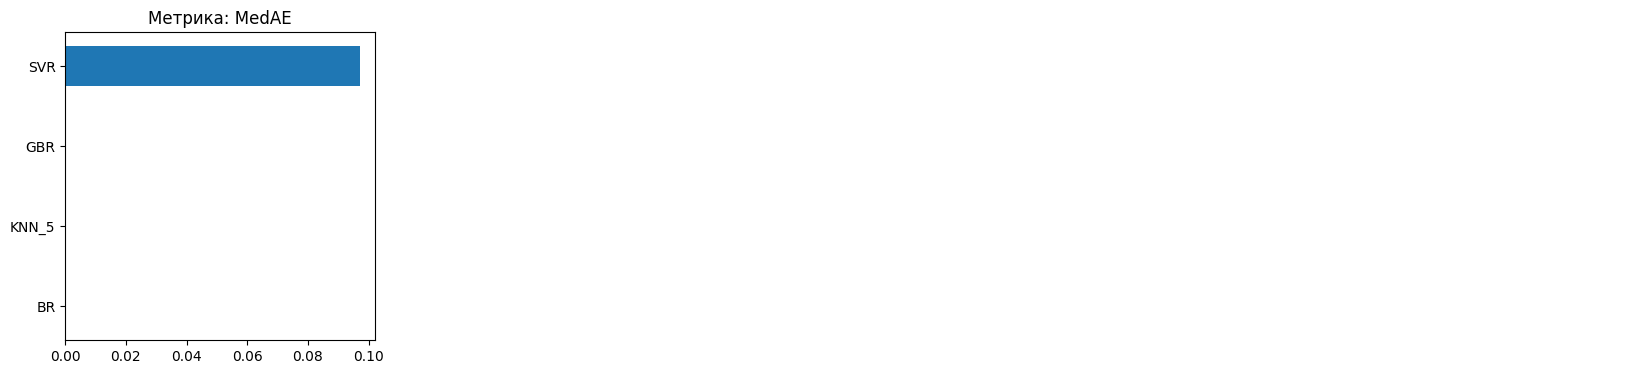

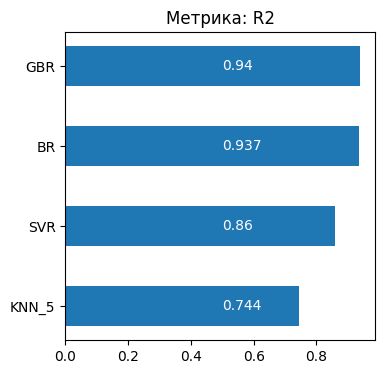

In [185]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    best_mlogger.plot('Метрика: ' + metric, metric,)

Из моделей с автоматически подобранными гиперпараметрами наилучшей является модель градиентного бустинга. Она также имеет лучшие значения метрик, чем наилучшая baseline-модель.